In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import multiprocessing as mp

from matplotlib import rcParams
rcParams['font.family'] = 'stixgeneral'
rcParams['text.usetex'] = False
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16

import vplanet_inference as vpi

### XUV luminosity model from [Ribas et al. 2005](https://iopscience.iop.org/article/10.1086/427977) (R05)

\begin{align}
\frac{L_\mathrm{XUV}}{L_\mathrm{bol}} = \left\{
				\begin{array}{lcr}
					f_\mathrm{sat} &\ & t \leq t_\mathrm{sat} \\
					f_\mathrm{sat}\left(\frac{t}{t_\mathrm{sat}}\right)^{-\beta_\mathrm{XUV}} &\ & t > t_\mathrm{sat}
				\end{array}
				\right.,
\end{align}

where 

$L_\mathrm{XUV} / L_\mathrm{bol}$ is the ratio of X-ray luminosity to bolometric (total) luminosity

$f_{sat}$ is the constant ratio of stellar XUV to bolometric luminosity during the saturated phase

$t_{sat}$ is the duration of the saturated phase

$\beta_{XUV}$ is the exponent that controls how steeply $L_{\rm XUV}$ decays after saturation

### XUV luminosity model from [Johnstone et al. 2021](https://arxiv.org/abs/2009.07695) (J21)

\begin{equation} 
    \frac{L_\mathrm{X}}{L_\mathrm{bol}} = \left \{
    \begin{array}{ll}
    C_1 Ro^{\beta_1}, & \text{if }  Ro \ge Ro_\mathrm{sat},\\
    C_2 Ro^{\beta_2}, & \text{if }  Ro \le Ro_\mathrm{sat},\\
    \end{array} \right.
\end{equation}

where 

$L_\mathrm{X} / L_\mathrm{bol}$ is the ratio of X-ray luminosity to bolometric (total) luminosity

$R_o$ is the Rossby number (the rotation period / convective turnover timescale of the star)

$C_1$, $C_2$, $\beta_1$, and $\beta_2$ are constants

### Best fit values from the paper:

$\beta_1 = -0.135 \pm 0.030$

$\beta_2 = -1.889 \pm 0.079$

$Ro_\mathrm{sat} = 0.0605 \pm 0.00331$

$R_\mathrm{X,sat} = 5.135 \times 10^{-4} \pm 3.320 \times 10^{-5}$

$R_\mathrm{X,sat}$ is the value of $R_\mathrm{X}$ at $Ro_\mathrm{sat}$
and the constants $C_1$, $C_2$ can be solved for using the relation:
$R_\mathrm{X,sat} = C_1 Ro_\mathrm{sat}^{\alpha_1} = C_2 Ro_\mathrm{sat}^{\alpha_2}$

Why we will use the Johnstone 2021 model:
- model parameters are not dependent on stellar mass
- constants have been empirically calibrated from a large sample of FGKM dwarfs (see Figure 4 of the paper)

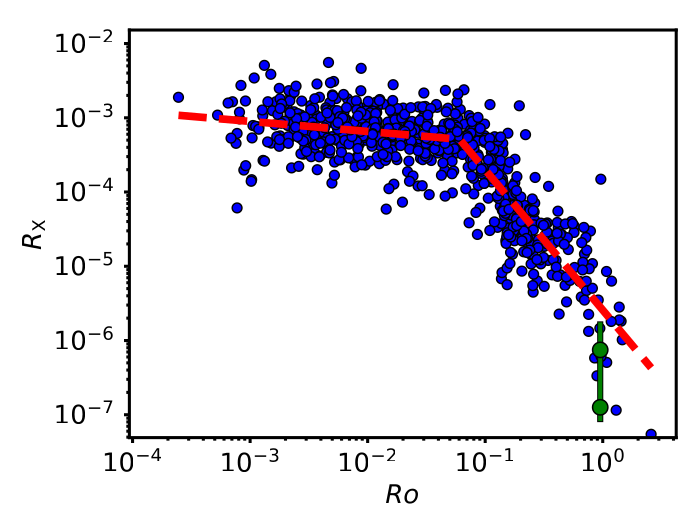


In [2]:
# To run implement the Johnstone model, we will define the mean and uncertainty for the model parameters

j21 = {"beta1": (-0.135, 0.030),
       "beta2": (-1.889, 0.079),
       "Rosat": (0.0605, 0.00331),
       "RXsat": (5.135e-4, 3.320e-5)}

In [3]:
# Initialize the vplanet model with the input and output parameters

inpath = "../infiles/stellar/"
outpath = "output/"

inparams = {"star.dMass": u.Msun,
            "star.dRotPeriod": u.days,
            "vpl.dStopTime": u.Gyr}

outparams = {"final.star.Luminosity": u.Lsun,
             "final.star.RotPer": u.days,
             "final.star.RossbyNumber": u.dimensionless_unscaled,
             "final.star.Radius": u.Rsun}

vpm = vpi.VplanetModel(inparams=inparams,
                       outparams=outparams,
                       inpath=inpath,
                       outpath=outpath,
                       time_init=5e6*u.yr,
                       timesteps=1e6*u.yr,
                       verbose=True)

In [4]:
# Implement the additional equations needed for the Johnstone XUV luminosity model

def FluxToLuminosity(Flux,Radius):
    Luminosity = Flux * 4 * np.pi * Radius**2
    return Luminosity

def LuminosityToFlux(Luminosity, Radius):
    Flux = Luminosity/(Radius**2 * 4 * np.pi)
    return Flux

def EUV_relation(LuminosityXray, Radius):
    FluxXray = LuminosityToFlux(LuminosityXray.cgs.value, Radius.cgs.value)
    logFluxEUV1 = 2.04 + 0.681 * np.log10(FluxXray)
    FluxEUV1 = 10**logFluxEUV1
    logFluxEUV2 = -0.341 + 0.920 * logFluxEUV1
    FluxEUV2 = 10**logFluxEUV2
    FluxEUV = (FluxEUV1 + FluxEUV2) * u.erg / u.s / u.cm**2
    LuminosityEUV = FluxToLuminosity(FluxEUV, Radius)
    
    return LuminosityEUV



def LXUV_model(mstar, prot, age, beta1, beta2, Rosat, RXsat):

    evol = vpm.run_model(np.array([mstar, prot, age]), remove=True)
    ross = evol["final.star.RossbyNumber"]
    lbol = evol["final.star.Luminosity"]
    Radius = evol["final.star.Radius"]

    C1 = RXsat / Rosat**beta1
    C2 = RXsat / Rosat**beta2
    
    rx = np.zeros(len(ross))
    for ii in range(len(ross)):
        if ross[ii] < Rosat:
            rx[ii] = C1 * ross[ii]**beta1
        else:
            rx[ii] = C2 * ross[ii]**beta2

    evol["final.star.RX"] = rx
    evol["final.star.LXray"] = rx * lbol
    evol["final.star.LEUV"] = EUV_relation(evol["final.star.LXray"], Radius)
    evol["final.star.LXUV"] = evol["final.star.LXray"] + evol["final.star.LEUV"]

    return evol

Test the Johnstone model for a single star with $M_* = 1\, M_{\odot}$, initial $P_{\rm rot} = 0.5$ days, $t_{\rm age} = 9$ Gyr, and constants ($\beta_1$, $\beta_2$, $Ro_\mathrm{sat}$, $R_\mathrm{X,sat}$) from the J21 paper:

In [5]:
# inputs: theta = [mstar, prot, age, beta1, beta2, Rosat, RXsat]

theta = np.array([0.85, 38.8, 10.2, j21["beta1"][0], j21["beta2"][0], j21["Rosat"][0], j21["RXsat"][0]])
evol = LXUV_model(*theta)


Input:
-----------------
star.dMass : 0.85 [solMass] (user)   --->   1.6901483900933434e+30 [kg] (vpl file)
star.dRotPeriod : 38.8 [days] (user)   --->   3352319.9999999995 [s] (vpl file)
vpl.dStopTime : 10.2 [Gyr] (user)   --->   3.2188752e+17 [s] (vpl file)

Created file output//3714111345442/vpl.in
Created file output//3714111345442/star.in
Executed model output//3714111345442/vpl.in 13.312 s

Output:
-----------------
final.star.Luminosity : 0.5039135318704284 [solLum]
final.star.Radius : 0.8663715682046859 [solRad]
final.star.RossbyNumber : 2.787834 []
final.star.RotPer : 57.51443287037037 [days]



In [6]:
def plot_evolution(evols, title="55 Cnc Samples"):

    fig, axs = plt.subplots(3, 1, figsize=[10,14], sharex=True)

    for evol in evols:
        lbol = evol["final.star.Luminosity"].to(u.erg/u.s)
        lxuv = evol["final.star.LXUV"].to(u.erg/u.s)
        prot = evol["final.star.RotPer"]

        axs[0].plot(evol["Time"], lbol, color="k", alpha=0.5)
        axs[1].plot(evol["Time"], lxuv, color="k", alpha=0.5)
        axs[2].plot(evol["Time"], prot, color="k", alpha=0.5)

    axs[0].set_title(title, fontsize=24)
    axs[0].set_ylabel("Bolometric Luminosity [{}]".format(lbol.unit), fontsize=20)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    axs[1].set_ylabel("XUV Luminosity [{}]".format(lxuv.unit), fontsize=20)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    axs[2].set_ylabel("Rotation Period [{}]".format(prot.unit), fontsize=20)
    axs[2].set_xlabel("Time [yr]", fontsize=20)
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')

    axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
    plt.tight_layout()
    
    return fig

/tmp/ipykernel_37545/1370914554.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))


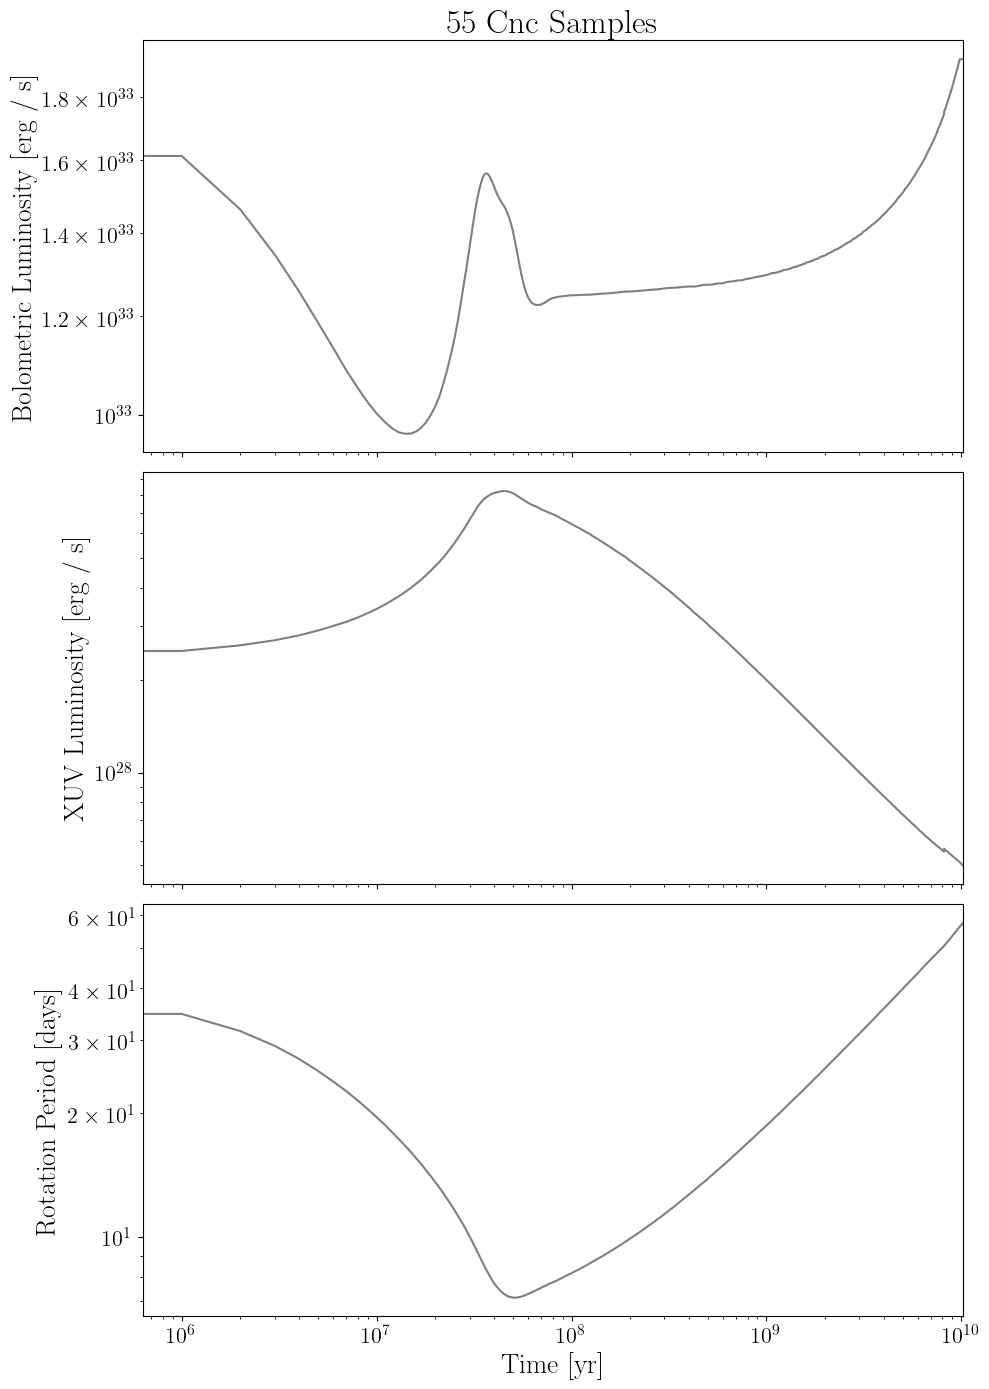

In [7]:
plot_evolution([evol]);

# note that the input to the plot_evolution function is a list of dictionaries, where each dictionary is the output of the LXUV_model function
# since evol is a single dictionary, we add brackets around it to make it a list

### Parameter sweep

Let's try sampling a range of different plausible models for Trappist-1, given the known parameters and uncertainties

In [8]:
# 55 Cnc

nsamp = 20
mass_samp = np.random.normal(0.85, 0.02, nsamp)
prot_samp = np.random.uniform(38.8, 0.05, nsamp)
age_samp = np.ones(nsamp) * 10.2
beta1_samp = np.random.normal(j21["beta1"][0], j21["beta1"][1], nsamp)
beta2_samp = np.random.normal(j21["beta2"][0], j21["beta2"][1], nsamp)
Rosat_samp = np.random.normal(j21["Rosat"][0], j21["Rosat"][1], nsamp)
RXsat_samp = np.random.normal(j21["RXsat"][0], j21["RXsat"][1], nsamp)

thetas = np.array([mass_samp, prot_samp, age_samp, beta1_samp, beta2_samp, Rosat_samp, RXsat_samp]).T

# Run with multiple cores
ncores = mp.cpu_count()
print("number of cores available:", ncores)
with mp.Pool(ncores) as pool:
    evols = pool.starmap(LXUV_model, thetas)

# If multiple cores does not work, comment out the previous two lines and uncomment the following lines 
# evols = []
# for ii in range(nsamp):
#     evols.append(LXUV_model(*thetas[ii]))

number of cores available: 12



Input:
Input:
Input:
Input:
Input:

Input:
Input:
Input:


Input:

Input:

Input:-----------------
Input:
-----------------
-----------------




--------------------------------------------------------------------
----------------------------------


---------------------------------------------------

star.dMass : 0.8207928284060467 [solMass] (user)   --->   1.632072561800755e+30 [kg] (vpl file)
star.dMass : 0.8485208291439513 [solMass] (user)   --->   1.687207192162727e+30 [kg] (vpl file)


star.dMass : 0.8326325408231653 [solMass] (user)   --->   1.6556147628371798e+30 [kg] (vpl file)star.dMass : 0.8273750205357764 [solMass] (user)   --->   1.6451606576023404e+30 [kg] (vpl file)

star.dMass : 0.868514811001981 [solMass] (user)   --->   1.726963423043791e+30 [kg] (vpl file)star.dMass : 0.8260847737759428 [solMass] (user)   --->   1.6425951182094512e+30 [kg] (vpl file)
star.dMass : 0.8727166124103021 [solMass] (user)   --->   1.73531832643881e+30 [kg] (vpl file)star.dMass : 0.872845

Next, let's plot the models we just ran and see how the evolution models (black lines) compare to the observational data (red lines) of the system at present day 
using data from [https://jbirky.github.io/yupra/docs/datasets.html](https://jbirky.github.io/yupra/docs/datasets.html)

Note: make sure that the units are consistent with those in the data table.

Then plot the observational constraints and uncertainties on top of the models, to compare how well the models match the data.

In [9]:
# data = [mean/value, lower error, upper error]

Lbol_data = np.array([0.582, -0.014, 0.014]) * u.Lsun
Lbol_data = Lbol_data.to(u.erg/u.s).value

Lxuv_data = np.array([6.05e+26, -5.23e+25, 5.23e+25]) * u.Lsun
Lxuv_data = Lxuv_data.value

Prot_data = np.array([38.8, -0.05, 0.05]) * u.day
Prot_data = Prot_data.value

age_data = np.array([10.2, -2.5, 2.5]) * u.Gyr
age_data = age_data.to(u.yr).value

/tmp/ipykernel_37545/1370914554.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
/tmp/ipykernel_37545/2978703677.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


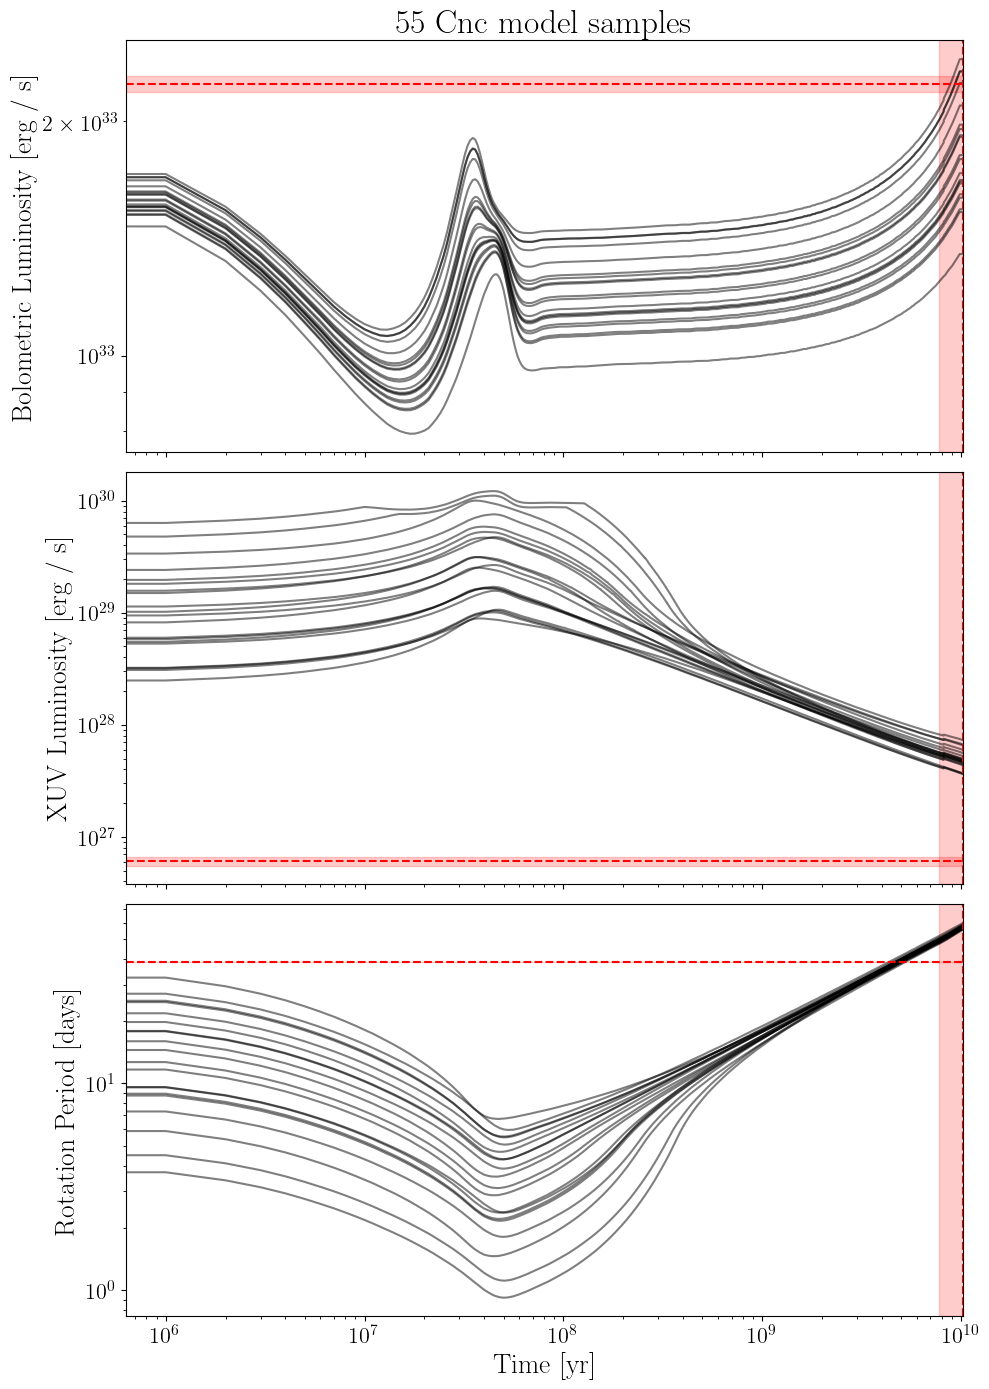

In [10]:
fig = plot_evolution(evols, title="55 Cnc model samples")
axs = fig.axes

axs[0].axhline(Lbol_data[0], color="r", linestyle="--")
axs[0].axhspan(Lbol_data[0]+Lbol_data[1], Lbol_data[0]+Lbol_data[2], color="r", alpha=0.2)

axs[1].axhline(Lxuv_data[0], color="r", linestyle="--")
axs[1].axhspan(Lxuv_data[0]+Lxuv_data[1], Lxuv_data[0]+Lxuv_data[2], color="r", alpha=0.2)

axs[2].axhline(Prot_data[0], color="r", linestyle="--")
axs[2].axhspan(Prot_data[0]+Prot_data[1], Prot_data[0]+Prot_data[2], color="r", alpha=0.2)

for ii in range(len(axs)):
    axs[ii].axvline(age_data[0], color="r", linestyle="--")
    axs[ii].axvspan(age_data[0]+age_data[1], age_data[0]+age_data[2], color="r", alpha=0.2)

fig.show()

Note: for the Trappist system, the constraints on rotation period and xray luminosity suggest a younger age (~1-3 Gyr, based on where the models intersect the horizontal red lines) than what is reported in literature ($7.6\pm2.2$ Gyr, from Burgasser and Mamajek 2017). However, age is one of the most difficult parameters to reliably measure for a star, so it is not too surprising that the literature age is inconsistent.

In [11]:
model1_finalXUV = (evols[0]["final.star.LXUV"][-1]).to(u.erg/u.s).value
(model1_finalXUV - Lxuv_data[0])**2/Lxuv_data[1]**2
# closer to 0 is less deviation, getting mean from the data and comparing to original mean, chi squared 

6894.435404446652